100%|██████████| 9.91M/9.91M [00:00<00:00, 18.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 494kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.89MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.0MB/s]


Epoch [1/5], Step [100/938], Loss: 0.6919
Epoch [1/5], Step [200/938], Loss: 0.6110
Epoch [1/5], Step [300/938], Loss: 0.2461
Epoch [1/5], Step [400/938], Loss: 0.2279
Epoch [1/5], Step [500/938], Loss: 0.1725
Epoch [1/5], Step [600/938], Loss: 0.1764
Epoch [1/5], Step [700/938], Loss: 0.3140
Epoch [1/5], Step [800/938], Loss: 0.1503
Epoch [1/5], Step [900/938], Loss: 0.2070
Epoch [1/5], Average Loss: 0.3622
Epoch [2/5], Step [100/938], Loss: 0.0604
Epoch [2/5], Step [200/938], Loss: 0.3191
Epoch [2/5], Step [300/938], Loss: 0.0169
Epoch [2/5], Step [400/938], Loss: 0.0439
Epoch [2/5], Step [500/938], Loss: 0.1542
Epoch [2/5], Step [600/938], Loss: 0.0683
Epoch [2/5], Step [700/938], Loss: 0.0497
Epoch [2/5], Step [800/938], Loss: 0.1103
Epoch [2/5], Step [900/938], Loss: 0.2244
Epoch [2/5], Average Loss: 0.1130
Epoch [3/5], Step [100/938], Loss: 0.0170
Epoch [3/5], Step [200/938], Loss: 0.0750
Epoch [3/5], Step [300/938], Loss: 0.0338
Epoch [3/5], Step [400/938], Loss: 0.1004
Epoch [3

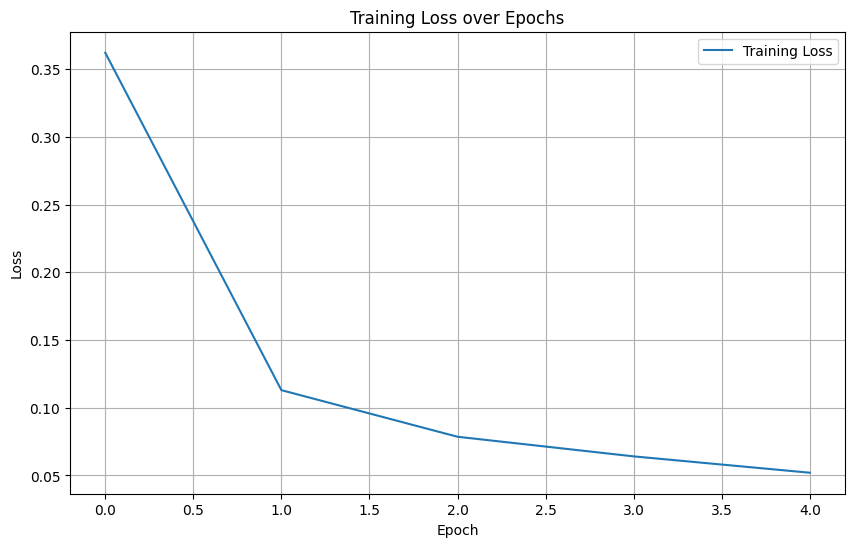

Test Accuracy: 98.14%


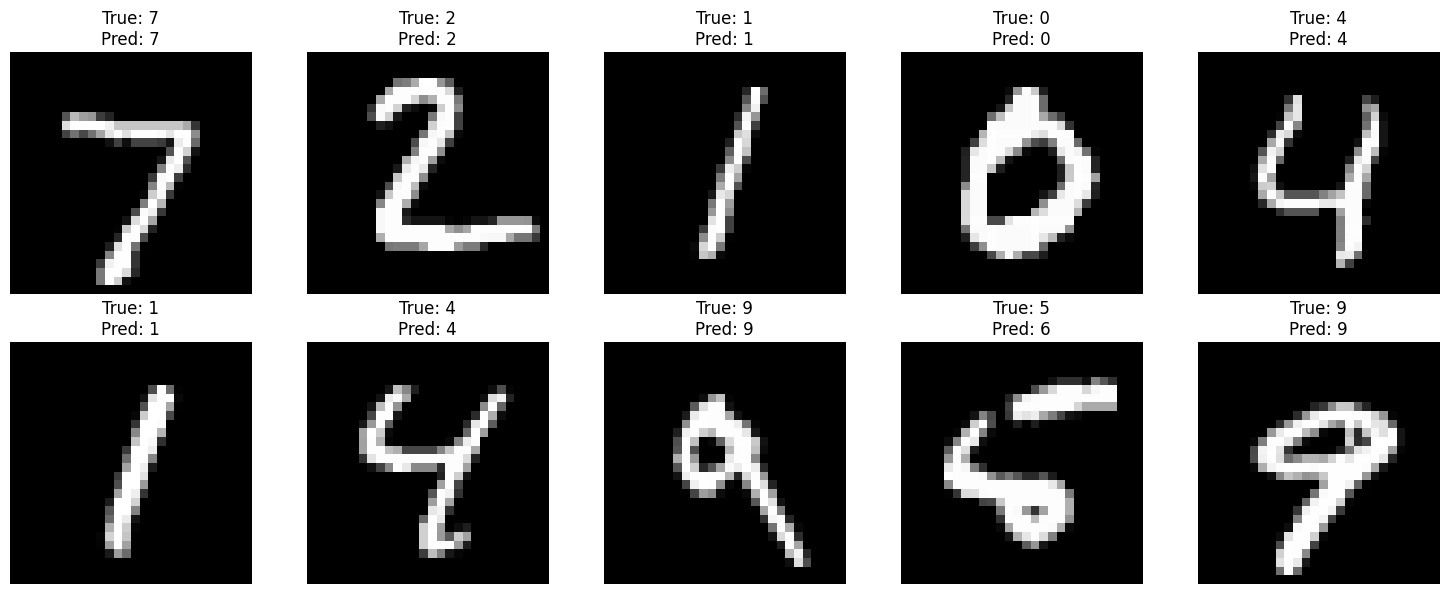

In [1]:
# ============================================================
# Assignment: Manual LSTM Cell for MNIST Digit Classification
# ============================================================
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os

# ============================================================
# Hyperparameters - tuned for better accuracy
# ============================================================
input_size = 28
hidden_size = 128  # Increased from 32 to 128
num_layers = 1
num_classes = 10
batch_size = 64    # Decreased from 128 to 64 for more updates
learning_rate = 0.001  # Increased from 0.00006
num_epochs = 5     # Increased from 2 to 5

# ============================================================
# Load the MNIST Dataset
# ============================================================
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# ============================================================
# TODO 1: Build Manual LSTM Cell
# ============================================================
class ManualLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ManualLSTMCell, self).__init__()

        # Define weights for the forget gate
        self.W_f = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.U_f = nn.Parameter(torch.Tensor(hidden_size, input_size))
        self.b_f = nn.Parameter(torch.Tensor(hidden_size))

        # Define weights for the input gate
        self.W_i = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.U_i = nn.Parameter(torch.Tensor(hidden_size, input_size))
        self.b_i = nn.Parameter(torch.Tensor(hidden_size))

        # Define weights for the output gate
        self.W_o = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.U_o = nn.Parameter(torch.Tensor(hidden_size, input_size))
        self.b_o = nn.Parameter(torch.Tensor(hidden_size))

        # Define weights for the candidate cell state
        self.W_c = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.U_c = nn.Parameter(torch.Tensor(hidden_size, input_size))
        self.b_c = nn.Parameter(torch.Tensor(hidden_size))

        # Initialize weights with Xavier/Glorot initialization
        self._init_weights()

    def _init_weights(self):
        for param in self.parameters():
            if param.dim() == 2:
                nn.init.xavier_uniform_(param)
            else:
                nn.init.zeros_(param)

        # Initialize forget gate bias to 1 to remember by default (helps with training)
        nn.init.ones_(self.b_f)

    def forward(self, x, h_prev, c_prev):
        # x shape: [batch_size, input_size]
        # h_prev shape: [batch_size, hidden_size]
        # c_prev shape: [batch_size, hidden_size]

        # Calculate forget gate
        f_t = torch.sigmoid(h_prev @ self.W_f.t() + x @ self.U_f.t() + self.b_f)

        # Calculate input gate
        i_t = torch.sigmoid(h_prev @ self.W_i.t() + x @ self.U_i.t() + self.b_i)

        # Calculate candidate cell state
        c_tilde = torch.tanh(h_prev @ self.W_c.t() + x @ self.U_c.t() + self.b_c)

        # Update cell state
        c_t = f_t * c_prev + i_t * c_tilde

        # Calculate output gate
        o_t = torch.sigmoid(h_prev @ self.W_o.t() + x @ self.U_o.t() + self.b_o)

        # Update hidden state
        h_t = o_t * torch.tanh(c_t)

        return h_t, c_t

# Full LSTM network
class ManualLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ManualLSTMClassifier, self).__init__()

        # Create ManualLSTMCell
        self.lstm_cell = ManualLSTMCell(input_size, hidden_size)

        # Create fully connected layer for classification
        self.fc = nn.Linear(hidden_size, num_classes)

        self.hidden_size = hidden_size
        self.input_size = input_size

    def forward(self, x):
        # x shape: [batch_size, seq_len, input_size]
        batch_size, seq_len, _ = x.size()

        # Initialize h_t and c_t to zeros
        h_t = torch.zeros(batch_size, self.hidden_size, device=x.device)
        c_t = torch.zeros(batch_size, self.hidden_size, device=x.device)

        # Unroll through the sequence (for each time step)
        for t in range(seq_len):
            # Current input at time step t
            x_t = x[:, t, :]

            # Update h_t and c_t
            h_t, c_t = self.lstm_cell(x_t, h_t, c_t)

        # Pass the final hidden state to fully connected layer
        out = self.fc(h_t)

        return out

# ============================================================
# Training and Testing
# ============================================================
# Define model, criterion, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ManualLSTMClassifier(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Track losses for plotting
train_losses = []

# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        # Reshape to [batch_size, seq_len, input_size]
        # Here, each row of the image is considered a time step
        images = images.reshape(-1, 28, 28).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    # Store average loss for this epoch
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_loss.png')
plt.show()

# TODO 2: Testing loop to print the accuracy
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_images = []

    for images, labels in test_loader:
        # Store some images for visualization
        if len(all_images) < 10:
            all_images.extend(images[:10 - len(all_images)])
            all_labels.extend(labels[:10 - len(all_labels)])

        # Reshape images and move to device
        images = images.reshape(-1, 28, 28).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # Store predictions
        all_preds.extend(predicted.cpu().numpy())

        # Update counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print final accuracy
    print(f'Test Accuracy: {100 * correct / total:.2f}%')

# ============================================================
# TODO 3: Visualization prediction
# Show 10 example images including true label and prediction
# ============================================================
# Ensure we have exactly 10 images for visualization
vis_images = all_images[:10]
vis_labels = all_labels[:10]

# Get predictions for these images
with torch.no_grad():
    model.eval()
    pred_labels = []
    for img in vis_images:
        img = img.unsqueeze(0).reshape(-1, 28, 28).to(device)
        output = model(img)
        _, predicted = torch.max(output.data, 1)
        pred_labels.append(predicted.item())

# Plot the images and predictions
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(10):
    axes[i].imshow(vis_images[i].squeeze(), cmap='gray')
    axes[i].set_title(f'True: {vis_labels[i]}\nPred: {pred_labels[i]}')
    axes[i].axis('off')

plt.tight_layout()
plt.savefig('predictions.png')
plt.show()